In [128]:
import sys

from kuramoto_sim import kuramoto_network
from izhi2019_wrapper import IzhiCell
import matplotlib.pyplot as plt
from utils import *
import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib inline

print('...done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
...done


In [100]:
# Simulation A has high variance in natural frequencies

random = np.random.RandomState(seed=100)
noscillators = 10
scaling = 0.5
coupling_A   = random.uniform(scaling*0.01, scaling*0.05, size=(noscillators, noscillators))
for i in range(noscillators):
    coupling_A[i,i] = 0.0
frequencies_A = random.uniform(4.0, 20.0, size=(noscillators,))
net_A = kuramoto_network(noscillators, frequencies_A, coupling_A, init_phases=None, seed=0)
phases_A, mean_phase_A, synchrony_A, times_A = net_A.simulate(12000., 120.)
angles_A     = phase_to_angle(phases_A.T, times_A[1] - times_A[0])
amplitudes_A = phase_to_amplitude(phases_A.T, frequencies_A, times_A)
print('done...')

done...


In [104]:
# Simulation B has low variance in natural frequencies

noscillators = 10
scaling      = 1.0
coupling_B   = random.uniform(scaling*0.01, scaling*0.05, size=(noscillators, noscillators))
for i in range(noscillators):
    coupling_B[i,i] = 0.0
frequencies_B = random.uniform(3.5, 4.5, size=(noscillators,))
net_B = kuramoto_network(noscillators, frequencies_B, coupling_B, init_phases=phases_A[-1,:], seed=0)
phases_B, mean_phase_B, synchrony_B, times_B = net_B.simulate(12000., 120.)
angles_B     = phase_to_angle(phases_B.T, times_B[1] - times_B[0])
amplitudes_B = phase_to_amplitude(phases_B.T, frequencies_B, times_B)
print('done...')

done...


In [105]:
# Sum oscillators
sum_A = np.sum(amplitudes_A, axis=1)
sum_B = np.sum(amplitudes_B, axis=1)
print('..done')

..done


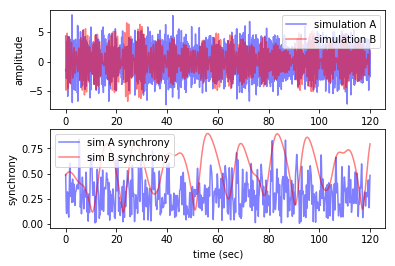

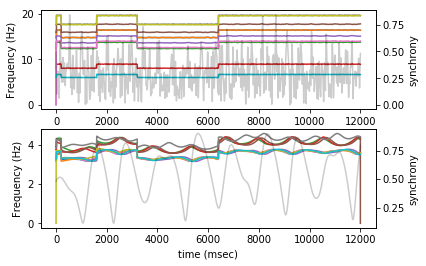

In [167]:
# Plot sum of oscillators and synchronization

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(times_A, sum_A, label='simulation A', c='b', alpha=0.5)
ax1.plot(times_B, sum_B, label='simulation B', c='r', alpha=0.5)
ax1.legend()

ax2.plot(times_A, synchrony_A, label='sim A synchrony', c='b', alpha=0.5)
ax2.plot(times_B, synchrony_B, label='sim B synchrony', c='r', alpha=0.5)
ax2.legend()

ax1.set_ylabel('amplitude')

ax2.set_ylabel('synchrony')
ax2.set_xlabel('time (sec)')

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(angles_A.T)
ax11 = ax1.twinx()
ax11.plot(synchrony_A, c='black', alpha=0.2)
ax2.plot(angles_B.T)
ax22 = ax2.twinx()
ax22.plot(synchrony_B, c='black', alpha=0.2)

ax1.set_ylabel('Frequency (Hz)')
ax11.set_ylabel('synchrony')

ax2.set_ylabel('Frequency (Hz)')
ax22.set_ylabel('synchrony')
ax2.set_xlabel('time (msec)')

plt.show()

In [107]:
# run simulations from parameter set A on pyramidal cell neurons

soma_v_vecs_A, t_vecs_A = [], []
simulation_time_idx_A = np.where(times_A < 5.)[0]
simulation_times_A    = times_A[simulation_time_idx_A]
sim_cells_A = [IzhiCell() for _ in xrange(noscillators)]
for i in xrange(noscillators):
    print(i)
    soma_v_vec_A, t_vec_A = run_neuron_simulation(sim_cells_A[i], amplitudes_A[simulation_time_idx_A,i], simulation_times_A * 1000.)
    soma_v_vecs_A.append(soma_v_vec_A)
    t_vecs_A.append(t_vec_A)
print('...done')


0
Changed dt
1
Changed dt
2
Changed dt
3
Changed dt
4
Changed dt
5
Changed dt
6
Changed dt
7
Changed dt
8
Changed dt
9
Changed dt
...done


In [108]:
# run simulations from parameter set B on pyramidal cell neurons

soma_v_vecs_B, t_vecs_B = [], []
simulation_time_idx_B = np.where(times_B < 5.0)[0]
simulation_times_B    = times_B[simulation_time_idx_B]
sim_cells_B = [IzhiCell() for _ in xrange(noscillators)]
for i in xrange(noscillators):
    print(i)
    soma_v_vec_B, t_vec_B = run_neuron_simulation(sim_cells_B[i], amplitudes_B[simulation_time_idx_B,i], simulation_times_B * 1000.)
    soma_v_vecs_B.append(soma_v_vec_B)
    t_vecs_B.append(t_vec_B)
print('...done')

0
Changed dt
1
Changed dt
2
Changed dt
3
Changed dt
4
Changed dt
5
Changed dt
6
Changed dt
7
Changed dt
8
Changed dt
9
Changed dt
...done


In [109]:
soma_voltages_A, soma_voltages_B = np.asarray(soma_v_vecs_A), np.asarray(soma_v_vecs_B)
neuron_times_A, neuron_times_B = np.asarray(t_vecs_A), np.asarray(t_vecs_B)

spike_times_A, spike_lst_A = extract_spikes(soma_voltages_A, neuron_times_A)
spike_times_B, spike_lst_B = extract_spikes(soma_voltages_B, neuron_times_B)

synchrony_A, synchrony_B = np.asarray(synchrony_A), np.asarray(synchrony_B)
synchrony_A_abridged = synchrony_A[simulation_time_idx_A]
synchrony_B_abridged = synchrony_B[simulation_time_idx_B]

chunk = 50 # ms
binned_network_activity_A, binned_times_A = bin_activity(neuron_times_A, spike_lst_A, noscillators, chunk=chunk)
binned_network_activity_B, binned_times_B = bin_activity(neuron_times_B, spike_lst_B, noscillators, chunk=chunk)
    
    
activity_A_mean, activity_A_std = np.mean(network_activation_A), np.std(network_activation_A)
activity_B_mean, activity_B_std = np.mean(network_activation_B), np.std(network_activation_B)

print('..done')

..done


In [157]:
network_activation_A = get_PSTH(binned_network_activity_A, noscillators, chunk/1000., filt=True)
network_activation_B = get_PSTH(binned_network_activity_B, noscillators, chunk/1000., filt=True)

ISI_A_lst, ISI_B_lst = [], []
cv_A_lst, cv_B_lst = [], []
for i in xrange(noscillators):
    ISI_A_lst.append(get_ISI(spike_times_A[i]))
    ISI_B_lst.append(get_ISI(spike_times_B[i]))
    cv_A_lst.append(get_CV(spike_times_A[i]))
    cv_B_lst.append(get_CV(spike_times_B[i]))
    
    
ifr_A, ifr_B = [], []
for i in xrange(noscillators):
    ifr_A.append(get_instantaneous_FR(spike_times_A[i], 0.025, t_start=0., t_stop=5000.))
    ifr_B.append(get_instantaneous_FR(spike_times_B[i], 0.025, t_start=0., t_stop=5000.))
    
print('..done')

..done


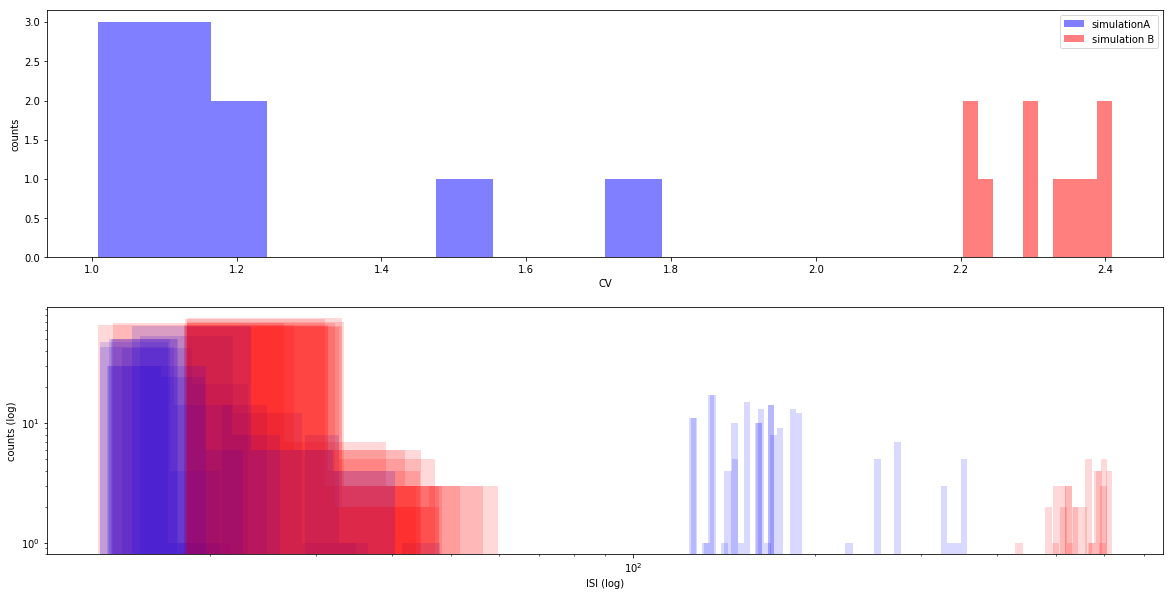

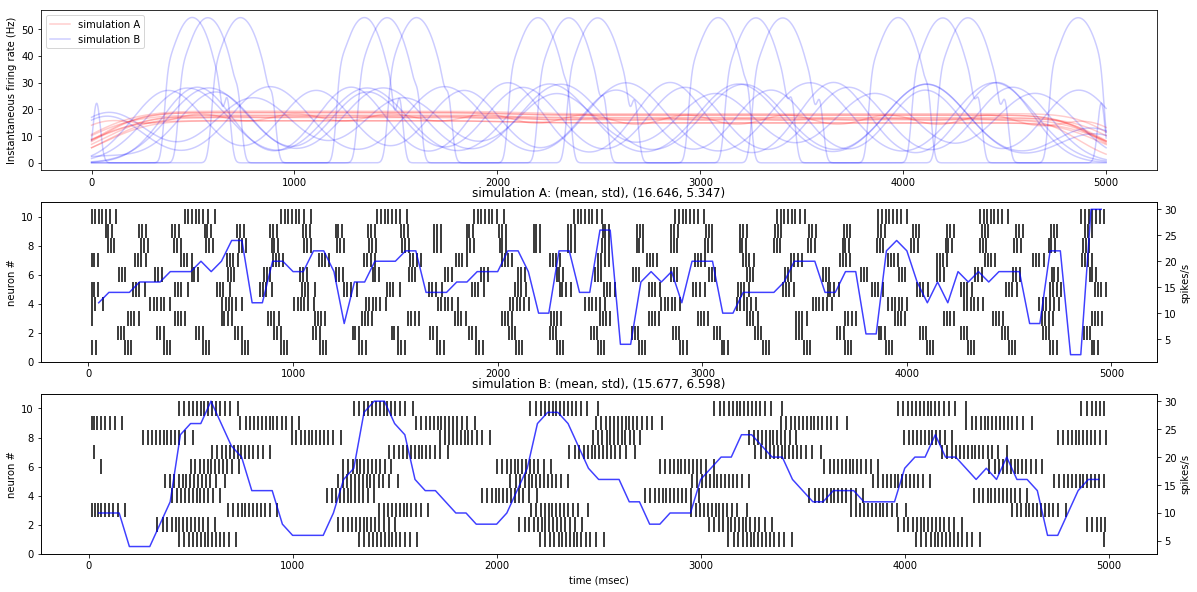

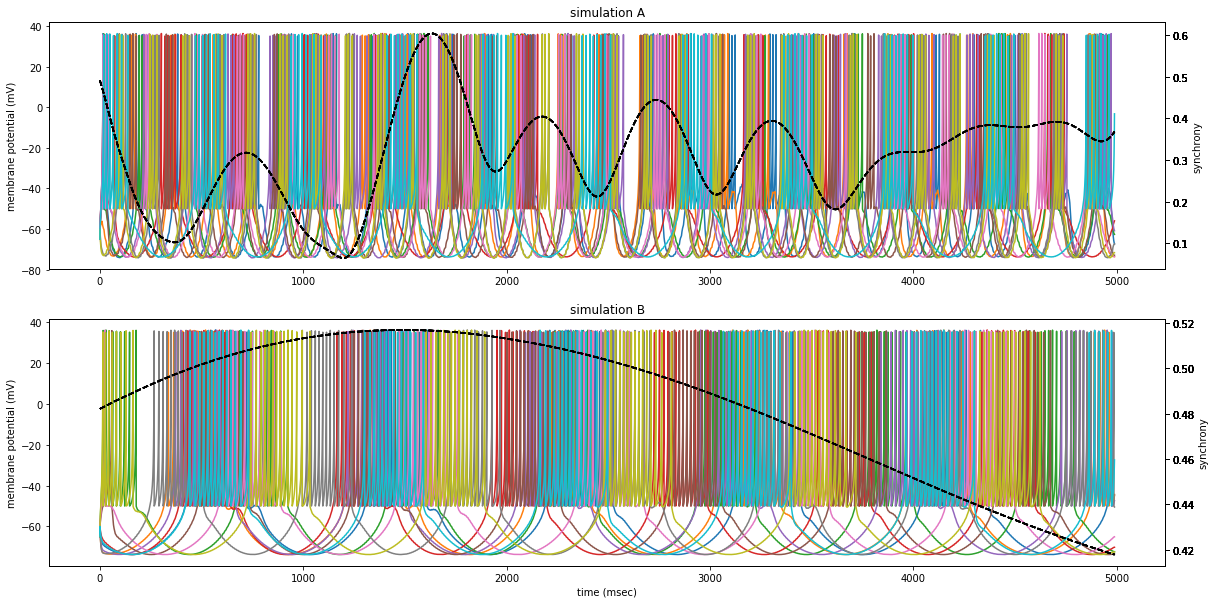

In [163]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))


ax1.hist(cv_A_lst, color='b', alpha=0.5, label='simulationA')
ax1.hist(cv_B_lst, color='r', alpha=0.5, label='simulation B')
ax1.legend()
ax1.set_xlabel('CV')
ax1.set_ylabel('counts')

for i in xrange(noscillators):
    ax2.hist(ISI_A_lst[i], bins=40, color='b', alpha=0.15)
    ax2.hist(ISI_B_lst[i], bins=40, color='r', alpha=0.15)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('ISI (log)')
ax2.set_ylabel('counts (log)')
plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,10))
ifr_times = np.arange(0., 5000., 0.025)
for i in xrange(noscillators):
    if i == noscillators - 1:
        ax1.plot(ifr_times, ifr_A[i], color='r', alpha=0.2, label='simulation A')
        ax1.plot(ifr_times, ifr_B[i], color='b', alpha=0.2, label='simulation B')
    else:
        ax1.plot(ifr_times, ifr_A[i], color='r', alpha=0.2)
        ax1.plot(ifr_times, ifr_B[i], color='b', alpha=0.2)
ax1.legend()
ax1.set_ylabel('Instantaneous firing rate (Hz)')

for i in xrange(len(spike_times_A)):
    ax2.vlines(spike_times_A[i], i + 0.5, i + 1.5)
    ax3.vlines(spike_times_B[i], i + 0.5, i + 1.5)
    ax2.set_ylabel('neuron #')
    ax3.set_ylabel('neuron #')
    ax2.set_title('simulation A: (mean, std), (%0.3f, %0.3f)' % (activity_A_mean, activity_A_std))
    ax3.set_title('simulation B: (mean, std), (%0.3f, %0.3f)' % (activity_B_mean, activity_B_std))
ax22 = ax2.twinx()
ax22.plot(binned_times_A[0], network_activation_A, c='b', alpha=0.75)
ax22.set_ylabel('spikes/s')
ax33 = ax3.twinx()
ax33.plot(binned_times_B[0], network_activation_B, c='b', alpha=0.75)
ax33.set_ylabel('spikes/s')
ax3.set_xlabel('time (msec)')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
for i in xrange(len(soma_voltages_A)):
    ax1.plot(neuron_times_A[i], soma_voltages_A[i,:])
    ax11 = ax1.twinx()
    ax11.plot(simulation_times_A*1000., synchrony_A_abridged, 'black', linestyle='--')
    ax2.plot(neuron_times_B[i], soma_voltages_B[i,:])
    ax22 = ax2.twinx()
    ax22.plot(simulation_times_B*1000., synchrony_B_abridged, 'black', linestyle='--')
    ax1.set_title('simulation A')
    ax2.set_title('simulation B')
    
ax1.set_ylabel('membrane potential (mV)')
ax11.set_ylabel('synchrony')
ax2.set_xlabel('time (msec)')
ax2.set_ylabel('membrane potential (mV)')
ax22.set_ylabel('synchrony')


plt.xlabel('time (msec)')
plt.show()
